# Détection d'intoxication alimentaire

Description de l'étude menée à New York: http://www.cdc.gov/mmwr/preview/mmwrhtml/mm6320a1.htm

Un article de Stanford pour détecter les épidémies via les messages twitter: http://snap.stanford.edu/soma2010/papers/soma2010_16.pdf

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas
from nltk.tokenize import word_tokenize
from nltk.tokenize import MWETokenizer
from nltk.tokenize import RegexpTokenizer
import nltk.data
from nltk import FreqDist
from nltk.sentiment import sentiment_analyzer
from unidecode import unidecode
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.stem import SnowballStemmer
import math
import word2vec
import unicodedata
import csv
import numpy as np
import matplotlib.pyplot as plt

In [4]:
stopwords = stopwords.words('french') # les mots les plus courants sont ignorés
stopwords = stopwords + ["les", "ils", "elles", "h", "a", 'ça', 'les']

On importe notre base de données.

In [6]:
df = pandas.read_csv("./data/base_DFG.csv", encoding = "utf-8")
print (df.shape)
df.head()

(85897, 10)


,Adresse,Code Postal,Commentaire,Date du commentaire,Note,Origine,Resto,Ville,Id,Date
0,63 AV MOZART,75016,Un accueil hyper chaleureux! Les gérants sont ...,30/04/2016,5,TripAdvisor,macis cafe,Paris,0,20160430.0
1,63 AV MOZART,75016,"Nous cherchions à déjeuner, seul bémol, l'heur...",21/04/2016,4,TripAdvisor,macis cafe,Paris,1,20160421.0
2,63 AV MOZART,75016,Des plats réalisés à partir de produits frais ...,10/02/2016,3,TripAdvisor,macis cafe,Paris,2,20160210.0
3,90 Rue des Orteaux,75020,Restaurant Sushi plutot correct dans l ensembl...,27/02/2016,3,TripAdvisor,sushi tomi,Paris,3,20160227.0
4,90 Rue des Orteaux,75020,Déçue de ma dernière visite car impossible de ...,17/01/2016,3,TripAdvisor,sushi tomi,Paris,4,20160117.0


# NLP

TO DO LIST:
- comparer les résultats avec le stem
- comparer des résultats en modifiant le critère de sélection des restaurants (mots clés, note d'hygiène)
- améliorer la sélection des mots des commentaires notés pour améliorer la pondération des mots et donc la notation des commentaires
- implémenter un algorithme de classification avec les deux notes moyennes et leur variance
- faire un nuage de point à chacune de nos étapes de sélection (liste de mots discriminant et score)
- choisir la meilleure méthode de sélection et récupérer l'adresse des restaurants concernés pour les représenter sur une carte

# Premier filtre de commentaires par mots clés

On crée une fonction pour tester la présence de mots clés dans un commentaire.

In [7]:
def mot_included(commentaire, mots):
    commentaire = unicodedata.normalize('NFKD', commentaire).encode('ASCII', 'ignore').decode('ASCII')        
    for mot in mots:
        if mot in commentaire:
            return True
    return False

In [8]:
mots_sales = ["indisposé", "malade",'intoxication','infection','parasite','virus','maux','fatigue','fièvre','vomi','diarrhée','indigestion',
              'nausée','sale','hygiène','vénéneux','dégueulasse','caca','chiasse','infame','douteux','barbouille',
              'crasse','honteux','suspect','repugnant','cracra','degoutant','souillé','louche','mauvaise','propre','colique',
             'dysenterie','débacle','pourrie','odeur', "infecte", "qualité", "déception", "désastre", "horrible", "honteux", "degueux", "important"]
stemmer = SnowballStemmer('french')
mots_sales = [unicodedata.normalize('NFKD', i).encode('ASCII', 'ignore').decode('ASCII') for i in mots_sales]
mots_sales_stem = [stemmer.stem(i) for i in mots_sales]
mots_sales_stem = [unicodedata.normalize('NFKD', i).encode('ASCII', 'ignore').decode('ASCII') for i in mots_sales_stem]

On récupère les commentaires concernés.

In [9]:
df_test = pandas.read_csv("./data/base_DFG.csv", encoding = "utf-8")
df_test['Sale'] = df_test['Commentaire'].apply(lambda x : mot_included(str(x), mots_sales_stem))
df_sale = df_test.query("Sale == True & Note in [1,2]")
df_sale.reset_index(drop=True, inplace=True)
print (df_sale.shape)
df_sale.head()

(5227, 11)


,Adresse,Code Postal,Commentaire,Date du commentaire,Note,Origine,Resto,Ville,Id,Date,Sale
0,"119, Rue Reuilly",75012,Vendredi soir et pas un plat typique du nord ....,18/03/2016,1,TripAdvisor,estaminet jenlain,Paris,7,20160318.0,True
1,54 Rue Mazarine,75006,"Ce dimanche matin passé , ayant entendu parler...",06/04/2016,2,TripAdvisor,gout de brioche,Paris,20,20160406.0,True
2,31 rue Bezout,75014,Ce qui fut un bon bistrot de quartier est deve...,30/01/2016,2,TripAdvisor,la table de bezout,Paris,24,20160130.0,True
3,19 Rue Lepic,75018,Je commande régulièrement depuis 4 ans dans ce...,25/04/2016,2,TripAdvisor,sushi shop,Paris,26,20160425.0,True
4,2 Rue Linois,75015,Cet Etablissement Marks & Spencer à tous les m...,18/04/2016,2,TripAdvisor,marks & spencer,Paris,31,20160418.0,True


In [10]:
resto_sale = []
for resto in df_sale.Resto.unique():
    nb = len(df_sale[df_sale.Resto == resto])
    if nb > 1 :
        resto_sale.append(resto)
df_sale_recurrent = df_sale.query("Resto in %s" %resto_sale)
df_sale_recurrent.reset_index(drop=True, inplace=True)
print("Restaurants potentiellement sales:", len(resto_sale))
print(df_sale_recurrent.shape)

Restaurants potentiellement sales: 1062
(3457, 11)


# Construction d'une liste de mots clés (active learning)

In [12]:
df_pond1 = pandas.read_csv("./data/Commentaires notés.csv", sep=";", encoding = "utf-8")
df_pond1.head()

,Adresse,Code Postal,Commentaire,Date du commentaire,Note,Origine,Resto,Ville,Id,Date,POND1
0,64 Avenue Des Ternes,,Menu unique à 75€ pour le réveillon pour un re...,04/01/2016,2,TripAdvisor,au petit marguery,Paris,941,20160104.0,0.0
1,162 Boulevard du Montparnasse,75014,"Mise en confiance par les avis positifs, j'ai ...",27/04/2016,1,TripAdvisor,il forno di napoli - trattoria napoletana,Paris,3717,20160427.0,0.0
2,162 Boulevard du Montparnasse,75014,Très médiocre .La pâte est molle(pas cuite) le...,25/03/2016,2,TripAdvisor,il forno di napoli - trattoria napoletana,Paris,3727,20160325.0,0.5
3,"102, Boulevard du Montparnasse",75014,Accueil horrible et sans politesse. Service in...,22/03/2016,1,TripAdvisor,la coupole,Paris,8074,20160322.0,0.0
4,"102, Boulevard du Montparnasse",75014,"Une grande déception, moi qui croyais découvri...",02/02/2016,2,TripAdvisor,la coupole,Paris,8145,20160202.0,1.0


Pour chacun de ces commentaires, on sélectionne les mots les plus discriminants.

In [13]:
sent_detector = nltk.data.load('tokenizers/punkt/french.pickle')
stemmer = SnowballStemmer('french')
tokenizer = RegexpTokenizer(r'\w+')

def compute_corpus(corpus, with_stemmer=True):
    dico = {}
    nb_sentence = 0
    for sentence in sent_detector.tokenize(corpus):
        nb_sentence += 1
        for token in tokenizer.tokenize(sentence.lower()):
            if token.lower() not in stopwords:
                if with_stemmer:
                    stem = stemmer.stem(token.lower())
                else:
                    stem = token.lower()
                if stem in dico:
                    dico[stem] += 1
                else:
                    dico[stem] = 1
    return dico

def tf_idf(commentaire, dico_corpus, with_stemmer=True):
    score = {}
    dico = {}
    for sentence in sent_detector.tokenize(commentaire):
        for token in tokenizer.tokenize(sentence.lower()):
            if token.lower() not in stopwords:
                if with_stemmer:
                    stem = stemmer.stem(token.lower())
                else:
                    stem = token.lower()
                if stem in dico:
                    dico[stem] += 1
                else:
                    dico[stem] = 1
    for mot in dico:
        score[mot] = dico[mot] * math.log(1 / dico_corpus[mot])
    return score

def tri_dico_byvalue(dico):
    sorted_value = sorted(set(dico.values()), reverse=True)
    sorted_key = []
    for i in sorted_value:
        for j in dico:
            if dico[j] == i:
                sorted_key.append(j)
    return sorted_key

On récupère l'ensemble de nos commentaires pour mesurer la fréquence d'apparition des mots.

In [14]:
corpus_commentaire = ""
for i in range (df.shape[0]):
    x = df.at[i, "Commentaire"]
    corpus_commentaire += " " + x
print(len(corpus_commentaire))

22802629


In [15]:
dico_corpus_stemmer = compute_corpus(corpus_commentaire)
dico_corpus = compute_corpus(corpus_commentaire, False)
with open('dico_corpus_stemmer.csv', 'w') as f:
    w = csv.DictWriter(f, dico_corpus_stemmer.keys())
    w.writeheader()
    w.writerow(dico_corpus_stemmer)
with open('dico_corpus.csv', 'w') as f:
    w = csv.DictWriter(f, dico_corpus.keys())
    w.writeheader()
    w.writerow(dico_corpus)

In [16]:
reader = csv.reader(open('dico_corpus_stemmer.csv', 'r'))
keys, values = reader
dico_corpus_stemmer = {}
n = len(keys)
for i in range(n):
    dico_corpus_stemmer[keys[i]] = values[i]
print(len(dico_corpus_stemmer))
reader = csv.reader(open('dico_corpus.csv', 'r'))
keys, values = reader
dico_corpus = {}
n = len(keys)
for i in range(n):
    dico_corpus[keys[i]] = int(values[i])
print(len(dico_corpus))

28924
49853


On pondère nos mots clés en fonction de la note d'hygiène attribuée à ces commentaires.

In [17]:
mot_cle = {}
frequence_mot = {}
for i in range(df_pond1.shape[0]):
    # on récupère le commentaire et sa note moyenne d'hygiène
    commentaire = df_pond1.at[i, "Commentaire"]
    note = df_pond1.at[i, "POND1"]
    # on récupère sa liste de mots les plus discriminants
    x = tri_dico_byvalue(tf_idf(commentaire, dico_corpus, False))
    n = int(len(x)/3) # on récupère le tiers des mots les plus discriminants
    mots_discriminants = x[:n]
    # pour chaque mot de cette liste, on lui associe la note du commentaire et note son apparition
    for mot in mots_discriminants:
        if mot in mot_cle:
            mot_cle[mot] += note
        else:
            mot_cle[mot] = note
        if mot in frequence_mot:
            frequence_mot[mot] += 1
        else:
            frequence_mot[mot] = 1

# pour chaque mot on calcule sa moyenne sur l'ensemble des commentaires dans lesquels il est apparu, plus un coefficient
for mot in mot_cle:
    mot_cle[mot] = (mot_cle[mot] / frequence_mot[mot]) 

len(mot_cle)

2519

10.0
0.0


(array([  2.07200000e+03,   2.77000000e+02,   8.90000000e+01,
          6.00000000e+00,   0.00000000e+00,   1.40000000e+01,
          1.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          5.90000000e+01]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.]),
 <a list of 10 Patch objects>)

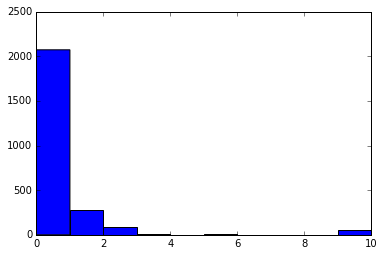

In [18]:
print(max(list(mot_cle.values())))
print(min(list(mot_cle.values())))
plt.hist(list(mot_cle.values()))

On ne garde que les mots les plus significatifs.

In [19]:
top_mot_cle = {}
for mot in mot_cle:
    if mot_cle[mot] > 6:
        top_mot_cle[mot] = mot_cle[mot]
print(len(top_mot_cle))
tri_dico_byvalue(top_mot_cle)

60


['poivre',
 'loc',
 'ventre',
 'obligé',
 'réfrigérateur',
 'nori',
 'assaisonnées',
 'proposé',
 'pompon',
 'écrevisse',
 'gaufres',
 'lac',
 'nantua',
 'criant',
 'intoxication',
 'lendemain',
 'sept',
 'scandaleux',
 'épicée',
 'vomi',
 'pulperia',
 'sourd',
 'infectes',
 'fraiches',
 'courent',
 'horribles',
 'marnière',
 'exception',
 'indigestion',
 'malades',
 'oreille',
 'gluante',
 'guère',
 'comprenons',
 'étonnant',
 '16',
 'chères',
 'cru',
 'attendaient',
 'miushi',
 'tombées',
 'hawai',
 'perte',
 'cuisiniers',
 'nuits',
 'désobligeantes',
 'commissariat',
 'remarques',
 'plas',
 'poubelle',
 'gave',
 'retiendra',
 'alimentaire',
 'gluant',
 'traversent',
 'pékinois',
 'potage',
 'canapés',
 'brulé',
 'malade']

# Notation automatique de l'hygiène de tous les commentaires

On attribue une note d'hygiène à tous les commentaires grâce à nos mots clés pondérés.

In [20]:
stemmer = SnowballStemmer('french')
tokenizer = RegexpTokenizer(r'\w+')
for i in range(df.shape[0]):
    df.at[i, "Pondération_hyg"] = 0 # on initialise nos valeurs
    commentaire = df.at[i, "Commentaire"]
    x = tri_dico_byvalue(tf_idf(commentaire, dico_corpus, False))
    nb_mots = 0
    x = x[:(int(len(x)/3))] # on ne récupère que le tiers des mots les plus discriminants pour le commentaire
    for mot in x:
        if mot in mot_cle:
            nb_mots += 1
            df.at[i, "Pondération_hyg"] += mot_cle[mot]
    if nb_mots != 0:
        df.at[i, "Pondération_hyg"] = df.at[i, "Pondération_hyg"] / nb_mots
    # on normalise notre note
    df.at[i,"Note_hyg"] = 5 - (df.at[i,"Pondération_hyg"] * 4 / 10)
del df["Pondération_hyg"]
df.head()

,Adresse,Code Postal,Commentaire,Date du commentaire,Note,Origine,Resto,Ville,Id,Date,Note_hyg
0,63 AV MOZART,75016,Un accueil hyper chaleureux! Les gérants sont ...,30/04/2016,5,TripAdvisor,macis cafe,Paris,0,20160430.0,5.000000
1,63 AV MOZART,75016,"Nous cherchions à déjeuner, seul bémol, l'heur...",21/04/2016,4,TripAdvisor,macis cafe,Paris,1,20160421.0,4.800000
2,63 AV MOZART,75016,Des plats réalisés à partir de produits frais ...,10/02/2016,3,TripAdvisor,macis cafe,Paris,2,20160210.0,5.000000
3,90 Rue des Orteaux,75020,Restaurant Sushi plutot correct dans l ensembl...,27/02/2016,3,TripAdvisor,sushi tomi,Paris,3,20160227.0,4.833333
4,90 Rue des Orteaux,75020,Déçue de ma dernière visite car impossible de ...,17/01/2016,3,TripAdvisor,sushi tomi,Paris,4,20160117.0,4.900000


5.0
1.0


(array([  4.91000000e+02,   1.20000000e+01,   7.00000000e+00,
          3.00000000e+01,   3.20000000e+02,   6.73000000e+02,
          8.49000000e+02,   1.16500000e+03,   3.36200000e+03,
          7.89880000e+04]),
 array([ 1. ,  1.4,  1.8,  2.2,  2.6,  3. ,  3.4,  3.8,  4.2,  4.6,  5. ]),
 <a list of 10 Patch objects>)

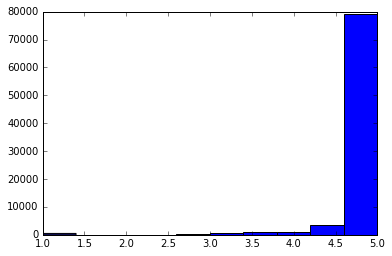

In [21]:
print(max(df.Note_hyg))
print(min(df.Note_hyg))
plt.hist(list(df.Note_hyg))

# Classification

Pour chaque restaurant, on calcul ses notes moyennes et la variance des notes de ses commentaires.

In [22]:
k = 5 # seuil au delà duquel les notes d'hygiène ne sont pas prise en compte
informations_restos = {}
liste_nom_resto = df.Resto.unique()
for resto in liste_nom_resto:
    df_resto = df[df.Resto == resto]
    note_off_resto = sum(df_resto.Note)/len(df_resto.Note)
    if len(df_resto[df_resto.Note_hyg < k].Note_hyg) > 0:
        note_hyg_resto = sum(df_resto[df_resto.Note_hyg < k].Note_hyg)/len(df_resto[df_resto.Note_hyg < k].Note_hyg)
    else:
        note_hyg_resto = sum(df_resto.Note_hyg)/len(df_resto.Note_hyg)
    var_off = np.var(df_resto.Note)
    var_hyg = np.var(df_resto[df_resto.Note_hyg < k].Note_hyg)
    informations_restos[resto] = (note_off_resto, note_hyg_resto, var_off, var_hyg)

In [23]:
for i in range(df.shape[0]):
    resto = df.at[i, "Resto"]
    df.at[i, "Note_resto"] = informations_restos[resto][0]
    df.at[i, "Note_hygiène_resto"] = informations_restos[resto][1]
    df.at[i, "Variance_note_resto"] = informations_restos[resto][2]
    df.at[i, "Variance_note_hygiène_resto"] = informations_restos[resto][3]

In [24]:
df.head()

,Adresse,Code Postal,Commentaire,Date du commentaire,Note,Origine,Resto,Ville,Id,Date,Note_hyg,Note_resto,Note_hygiène_resto,Variance_note_resto,Variance_note_hygiène_resto
0,63 AV MOZART,75016,Un accueil hyper chaleureux! Les gérants sont ...,30/04/2016,5,TripAdvisor,macis cafe,Paris,0,20160430.0,5.000000,4.0,4.800000,0.666667,0.000000
1,63 AV MOZART,75016,"Nous cherchions à déjeuner, seul bémol, l'heur...",21/04/2016,4,TripAdvisor,macis cafe,Paris,1,20160421.0,4.800000,4.0,4.800000,0.666667,0.000000
2,63 AV MOZART,75016,Des plats réalisés à partir de produits frais ...,10/02/2016,3,TripAdvisor,macis cafe,Paris,2,20160210.0,5.000000,4.0,4.800000,0.666667,0.000000
3,90 Rue des Orteaux,75020,Restaurant Sushi plutot correct dans l ensembl...,27/02/2016,3,TripAdvisor,sushi tomi,Paris,3,20160227.0,4.833333,3.0,4.866667,0.000000,0.001111
4,90 Rue des Orteaux,75020,Déçue de ma dernière visite car impossible de ...,17/01/2016,3,TripAdvisor,sushi tomi,Paris,4,20160117.0,4.900000,3.0,4.866667,0.000000,0.001111


In [25]:
# Keep a copy of the notes
notes_file = "./data/base_DFG_note.csv"
df.to_csv(notes_file , index=False)

On fait des graphiques avec ces variables.

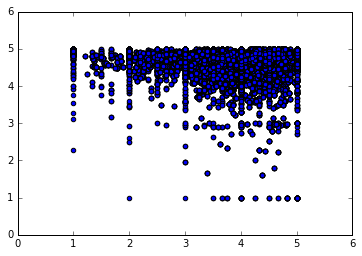

In [26]:
plt.scatter(df["Note_resto"] , df["Note_hygiène_resto"], s=20)
plt.show()

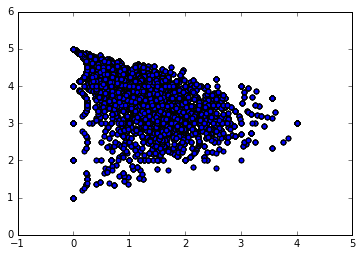

In [27]:
plt.scatter(df["Variance_note_resto"], df["Note_resto"], s=20)
plt.show()

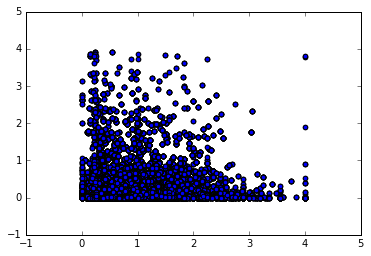

In [28]:
plt.scatter(df["Variance_note_resto"], df["Variance_note_hygiène_resto"])
plt.show()

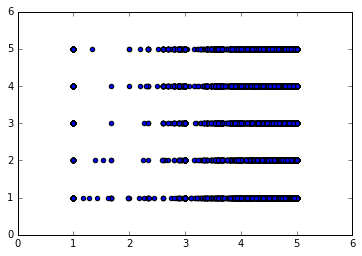

In [29]:
plt.scatter(df["Note_hyg"], df["Note"], s=20)
plt.show()

On applique sur nos restaurants un modèle de classification.

# Nuages de mots et carte

On reprend nos mots les plus discriminants, pondérés par leur fréquence d'apparition. 

In [30]:
score_nuage = {}
for mot in mot_cle:
    score_nuage[mot] = mot_cle[mot]
print(max(list(score_nuage.values())))
print(min(list(score_nuage.values())))
#tri_dico_byvalue(score_nuage)

10.0
0.0


In [31]:
top_score_nuage = {}
for mot in top_mot_cle:
    top_score_nuage[mot] = top_mot_cle[mot] / dico_corpus[mot]
print(max(list(top_score_nuage.values())))
print(min(list(top_score_nuage.values())))
print(len(top_score_nuage))
with open('top_score_nuage.csv', 'w') as f:
    w = csv.DictWriter(f, top_score_nuage.keys())
    w.writeheader()
    w.writerow(top_score_nuage)

10.0
0.0179533213645
60


In [32]:
reader = csv.reader(open('top_score_nuage.csv', 'r'))
keys, values = reader
top_score_nuage = {}
n = len(keys)
for i in range(n):
    top_score_nuage[keys[i]] = values[i]
print(len(top_score_nuage))
tri_dico_byvalue(top_score_nuage)

60


['infectes',
 'hawai',
 'commissariat',
 'plas',
 'gave',
 'pulperia',
 'miushi',
 'nori',
 'indigestion',
 'marnière',
 'sourd',
 'gluante',
 'traversent',
 'réfrigérateur',
 'désobligeantes',
 'nantua',
 'vomi',
 'retiendra',
 'écrevisse',
 'criant',
 'comprenons',
 'pompon',
 'nuits',
 'horribles',
 'pékinois',
 'brulé',
 'tombées',
 'perte',
 'malades',
 'sept',
 'attendaient',
 'poubelle',
 'courent',
 'intoxication',
 'assaisonnées',
 'gaufres',
 'loc',
 'guère',
 'scandaleux',
 'alimentaire',
 'oreille',
 'lac',
 'gluant',
 'potage',
 'remarques',
 'canapés',
 'lendemain',
 'épicée',
 'fraiches',
 'malade',
 'obligé',
 'ventre',
 'poivre',
 'cuisiniers',
 'étonnant',
 'chères',
 'exception',
 'cru',
 '16',
 'proposé']

On définit une fonction pour sélectionner les pires restaurants en terme d'hygiène.

In [33]:
def fonction_filtre_resto(liste_mot_cle, stem=False):
    # on transforme notre liste de mots clés
    stemmer = SnowballStemmer('french')
    liste_mot_cle = [unicodedata.normalize('NFKD', i).encode('ASCII', 'ignore').decode('ASCII') for i in liste_mot_cle]
    liste_mots_stem = [stemmer.stem(i) for i in liste_mot_cle]
    liste_mots_stem = [unicodedata.normalize('NFKD', i).encode('ASCII', 'ignore').decode('ASCII') for i in liste_mots_stem]

    print("Base de données:", df.shape, "==> df")
    # on réduit le dataframe aux mots clés et aux notes
    df_test = df.copy(deep=True)
    if stem:
        df_test['Sale'] = df_test['Commentaire'].apply(lambda x : mot_included(str(x), liste_mots_stem))
    else:
        df_test['Sale'] = df_test['Commentaire'].apply(lambda x : mot_included(str(x), liste_mot_cle))
    df_tres_sale = df_test.query("Sale == True & Note_hyg < 5 & Note in [1, 2]")
    del df_tres_sale["Sale"]
    df_tres_sale['Id_resto'] = df_tres_sale['Resto'] + " $ " + df_tres_sale['Adresse']
    df_tres_sale.reset_index(drop=True, inplace=True)
    print ("Mots clés et note de commentaire:", df_tres_sale.shape, "==> df_tres_sale")
    print("Restaurants potentiellement sales:", len(df_tres_sale.Id_resto.unique()))
    # on réduit le dataframe aux restaurants cités plusieurs fois
    resto_sale1 = []
    for resto in df_tres_sale.Id_resto.unique():
        nb = len(df_tres_sale[df_tres_sale.Id_resto == resto])
        if nb > 1 :
            resto_sale1.append(resto)
    df_tres_sale_recurrent = df_tres_sale.query("Id_resto in %s" %resto_sale1)
    df_tres_sale_recurrent.reset_index(drop=True, inplace=True)
    print("Restaurants récurrent:", df_tres_sale_recurrent.shape, "==> df_tres_sale_recurrent")
    print("Restaurants potentiellement sales:", len(resto_sale1))
    # on réduit le dataframe aux restaurants cités durant le même mois
    resto_sale2 = []
    for resto in df_tres_sale_recurrent.Id_resto.unique():
        df_resto = df_tres_sale_recurrent[df_tres_sale_recurrent.Id_resto == resto]
        df_resto.reset_index(drop=True, inplace=True)
        for i in range(df_resto.shape[0]):
            if df_resto.at[i, "Note_hyg"] < 3:
                datei = df_resto.at[i, "Date"]
                for j in range(df_resto.shape[0]):
                    if j != i:
                        if df_resto.at[j, "Note_hyg"] < 3:
                            datej = df_resto.at[j, "Date"]
                            # on vérifie que deux commentaires critique au moins ont été publiés à un moins d'intervalle maximum
                            if str(datei)[4:6] == str(datej)[4:6]:
                                resto_sale2.append(resto)
                            elif abs( int(str(datei)[4:6]) - int(str(datej)[4:6]) ) == 1:
                                start = min(datei, datej)
                                for n in range(1, 31):
                                    if (str(start)[4:6] in ["01", "03", "05", "07", "08", "10", "12"]) and (str(start)[6:8] == "31"):
                                        start = int("2016" + str(start)[4:6] + "01")
                                    elif (str(start)[4:6] in ["04", "06", "09", "11"]) and (str(start)[6:8] == "30"):
                                        start = int("2016" + str(start)[4:6] + "01")
                                    elif (str(start)[4:6] == "02") and (str(start)[6:8] == "29"):
                                        start = int("2016" + str(start)[4:6] + "01")
                                    else:
                                        start += 1
                                if str(max(datei, datej))[6:8] < str(start):
                                    resto_sale2.append(resto)
    resto_sale2 = list(set(resto_sale2))
    df_tres_sale_recurrent_date = df_tres_sale_recurrent.query("Id_resto in %s" %resto_sale2)
    df_tres_sale_recurrent_date.reset_index(drop=True, inplace=True)
    print("Date commentaires proche:", df_tres_sale_recurrent_date.shape, "==> df_tres_sale_recurrent_date")
    print("Restaurants potentiellement sales:", len(set(resto_sale2)))
    return df_tres_sale, df_tres_sale_recurrent, df_tres_sale_recurrent_date, resto_sale1, resto_sale2

In [34]:
def export_resto_cible(filename1, filename2, liste1, liste2):
    resto_cible1 = {}
    for i in liste1:
        i = i.split("$")
        resto_cible1[i[0]] = i[1]
    resto_cible2 = {}
    for i in liste2:
        i = i.split("$")
        resto_cible2[i[0]] = i[1]
    with open(filename1+'.csv', 'w') as f:
            w = csv.DictWriter(f, resto_cible1.keys())
            w.writeheader()
            w.writerow(resto_cible1)
    with open(filename2+'.csv', 'w') as f:
            w = csv.DictWriter(f, resto_cible2.keys())
            w.writeheader()
            w.writerow(resto_cible2)

In [35]:
def outcome_com (df):
    df.reset_index(drop=True, inplace=True)
    for i in range(df.shape[0]):
        print(df.at[i, "Resto"])
        print(df.at[i, "Date du commentaire"])
        print(df.at[i, "Note_hyg"])
        print(df.at[i, "Commentaire"])
        print("######")
        print("\n")

In [36]:
top_mot_cle

{'16': 10.0,
 'alimentaire': 10.0,
 'assaisonnées': 10.0,
 'attendaient': 10.0,
 'brulé': 10.0,
 'canapés': 10.0,
 'chères': 10.0,
 'commissariat': 10.0,
 'comprenons': 10.0,
 'courent': 10.0,
 'criant': 10.0,
 'cru': 10.0,
 'cuisiniers': 10.0,
 'désobligeantes': 10.0,
 'exception': 10.0,
 'fraiches': 10.0,
 'gaufres': 10.0,
 'gave': 10.0,
 'gluant': 10.0,
 'gluante': 10.0,
 'guère': 10.0,
 'hawai': 10.0,
 'horribles': 10.0,
 'indigestion': 10.0,
 'infectes': 10.0,
 'intoxication': 10.0,
 'lac': 10.0,
 'lendemain': 10.0,
 'loc': 10.0,
 'malade': 8.3333333333333339,
 'malades': 10.0,
 'marnière': 10.0,
 'miushi': 10.0,
 'nantua': 10.0,
 'nori': 10.0,
 'nuits': 10.0,
 'obligé': 10.0,
 'oreille': 10.0,
 'perte': 10.0,
 'plas': 10.0,
 'poivre': 10.0,
 'pompon': 10.0,
 'potage': 10.0,
 'poubelle': 10.0,
 'proposé': 10.0,
 'pulperia': 10.0,
 'pékinois': 10.0,
 'remarques': 10.0,
 'retiendra': 10.0,
 'réfrigérateur': 10.0,
 'scandaleux': 10.0,
 'sept': 10.0,
 'sourd': 10.0,
 'tombées': 10.0,


On filtre avec notre liste de mots clés créée automatiquement.

In [37]:
MLdf_tres_sale, MLdf_tres_sale_recurrent, MLdf_tres_sale_recurrent_date, MLresto_sale1, MLresto_sale2 = fonction_filtre_resto(list(top_mot_cle), stem=False)
MLdf_tres_sale_recurrent_date

Base de données: (85897, 15) ==> df
Mots clés et note de commentaire: (2202, 16) ==> df_tres_sale
Restaurants potentiellement sales: 1576
Restaurants récurrent: (1013, 16) ==> df_tres_sale_recurrent
Restaurants potentiellement sales: 387
Date commentaires proche: (13, 16) ==> df_tres_sale_recurrent_date
Restaurants potentiellement sales: 3


,Adresse,Code Postal,Commentaire,Date du commentaire,Note,Origine,Resto,Ville,Id,Date,Note_hyg,Note_resto,Note_hygiène_resto,Variance_note_resto,Variance_note_hygiène_resto,Id_resto
0,60 rue Pierre Charron,75008,"Les plats sont quelconques pas mauvais, mais p...",21/04/2016,2,TripAdvisor,ziti,Paris,49587,20160421.0,4.950000,3.153846,4.067460,1.514793,1.565797,ziti $ 60 rue Pierre Charron
1,60 rue Pierre Charron,75008,Nous avons dîner ce soir et nous Sommes très d...,05/03/2016,1,TripAdvisor,ziti,Paris,49592,20160305.0,2.600000,3.153846,4.067460,1.514793,1.565797,ziti $ 60 rue Pierre Charron
2,60 rue Pierre Charron,75008,Une cuisine goûteuse et un service de très bon...,07/02/2016,1,TripAdvisor,ziti,Paris,49598,20160207.0,1.666667,3.153846,4.067460,1.514793,1.565797,ziti $ 60 rue Pierre Charron
3,"33, avenue des Champs-Elysées",75008,"Un restaurant parfait pour les touristes, on p...",27/04/2016,2,TripAdvisor,pizza pino,Paris,67833,20160427.0,4.925000,2.925000,4.661603,1.669375,0.356162,"pizza pino $ 33, avenue des Champs-Elysées"
4,"33, avenue des Champs-Elysées",75008,Nous nous sommes arrêtés dans ce restaurant qu...,23/04/2016,2,TripAdvisor,pizza pino,Paris,67839,20160423.0,4.920000,2.925000,4.661603,1.669375,0.356162,"pizza pino $ 33, avenue des Champs-Elysées"
5,"33, avenue des Champs-Elysées",75008,J'ai commander une escalope parmigiana et frui...,15/02/2016,1,TripAdvisor,pizza pino,Paris,67889,20160215.0,4.866667,2.925000,4.661603,1.669375,0.356162,"pizza pino $ 33, avenue des Champs-Elysées"
6,"33, avenue des Champs-Elysées",75008,"Plat du jour ""livré"" en sept minutes, le soir ...",08/02/2016,2,TripAdvisor,pizza pino,Paris,67896,20160208.0,1.380000,2.925000,4.661603,1.669375,0.356162,"pizza pino $ 33, avenue des Champs-Elysées"
7,"33, avenue des Champs-Elysées",75008,Ce restaurant est vraiment un scandale. Trop c...,14/01/2016,1,TripAdvisor,pizza pino,Paris,67907,20160114.0,4.277778,2.925000,4.661603,1.669375,0.356162,"pizza pino $ 33, avenue des Champs-Elysées"
8,"33, avenue des Champs-Elysées",75008,Si vous venez ici-bas pour une pizza ne prenez...,06/01/2016,2,TripAdvisor,pizza pino,Paris,67910,20160106.0,4.800741,2.925000,4.661603,1.669375,0.356162,"pizza pino $ 33, avenue des Champs-Elysées"
9,"33, avenue des Champs-Elysées",75008,Nous avons pris deux pizzas différentes mais n...,02/01/2016,1,TripAdvisor,pizza pino,Paris,67916,20160102.0,1.666667,2.925000,4.661603,1.669375,0.356162,"pizza pino $ 33, avenue des Champs-Elysées"


On filtre avec une liste de mots clés créée de toute pièce.

In [38]:
nos_mots_sales = ["indispose", "malade", "intoxication", "diarrhee", "fatigue", "maux", "fievre", "vomi", "chiasse", "caca", "nausee", "indigestion", "barbouille", "colique", "dysenterie"]
df_tres_sale, df_tres_sale_recurrent, df_tres_sale_recurrent_date, resto_sale1, resto_sale2 = fonction_filtre_resto(nos_mots_sales, stem=False)
df_tres_sale_recurrent_date

Base de données: (85897, 15) ==> df
Mots clés et note de commentaire: (212, 16) ==> df_tres_sale
Restaurants potentiellement sales: 201
Restaurants récurrent: (21, 16) ==> df_tres_sale_recurrent
Restaurants potentiellement sales: 10
Date commentaires proche: (7, 16) ==> df_tres_sale_recurrent_date
Restaurants potentiellement sales: 3


,Adresse,Code Postal,Commentaire,Date du commentaire,Note,Origine,Resto,Ville,Id,Date,Note_hyg,Note_resto,Note_hygiène_resto,Variance_note_resto,Variance_note_hygiène_resto,Id_resto
0,60 rue Pierre Charron,75008,Nous avons dîner ce soir et nous Sommes très d...,05/03/2016,1,TripAdvisor,ziti,Paris,49592,20160305.0,2.600000,3.153846,4.067460,1.514793,1.565797,ziti $ 60 rue Pierre Charron
1,60 rue Pierre Charron,75008,Une cuisine goûteuse et un service de très bon...,07/02/2016,1,TripAdvisor,ziti,Paris,49598,20160207.0,1.666667,3.153846,4.067460,1.514793,1.565797,ziti $ 60 rue Pierre Charron
2,"33, avenue des Champs-Elysées",75008,"Plat du jour ""livré"" en sept minutes, le soir ...",08/02/2016,2,TripAdvisor,pizza pino,Paris,67896,20160208.0,1.380000,2.925000,4.661603,1.669375,0.356162,"pizza pino $ 33, avenue des Champs-Elysées"
3,"33, avenue des Champs-Elysées",75008,Nous avons pris deux pizzas différentes mais n...,02/01/2016,1,TripAdvisor,pizza pino,Paris,67916,20160102.0,1.666667,2.925000,4.661603,1.669375,0.356162,"pizza pino $ 33, avenue des Champs-Elysées"
4,"27, Quai de Grenelle",,Personnel vraiment désagréable. J'y suis allée...,05/03/2016,1,TripAdvisor,okito sushi,Paris,72898,20160305.0,1.983333,3.200000,2.891000,2.360000,1.676389,"okito sushi $ 27, Quai de Grenelle"
5,"27, Quai de Grenelle",,Formule à volonté pour 13 euros. Les sushis so...,18/02/2016,1,TripAdvisor,okito sushi,Paris,72901,20160218.0,2.360000,3.200000,2.891000,2.360000,1.676389,"okito sushi $ 27, Quai de Grenelle"
6,"27, Quai de Grenelle",,"Un japonais chinois. Nous y sommes à 5, 4 ont ...",09/01/2016,1,TripAdvisor,okito sushi,Paris,72904,20160109.0,3.000000,3.200000,2.891000,2.360000,1.676389,"okito sushi $ 27, Quai de Grenelle"


On récupère les restaurants et les adresses concernées.

In [39]:
MLresto_sale1

['quindici $ Centre Commercial Beaugrenelle - 7 Rue Linois',
 'le pachyderme $ 2 Bis Boulevard Saint Martin',
 "chez lili et marcel $ 1, Quai d'Austerlitz",
 'merci $ 111 Boulevard Beaumarchais',
 'le petit zinc $ 11 Rue St Benoit',
 'the place to... $ 47, avenue de Wagram',
 'léon de bruxelles - paris - place de la république $ 8 Place de la Republique',
 'le pigalle $ 9 rue Frochot',
 'hippopotamus paris bercy arena 12e $ 102 rue de Bercy',
 "l'abordage $ 2 Place Bergson",
 'le carré des invalides $ 129 Rue de Grenelle',
 'cafe le baron $ 11 rue de Chateaudun',
 'café république $ 9 place de la République',
 "l'horizon $ 120 rue de Rennes",
 'montreux jazz café $ Place Louis Armand',
 "l'institut $ 1 Boulevard Saint-Germain",
 'non coupable $ 21 Rue Auber',
 "bizz'art $ 167 quai de Valmy",
 'paris en seine $ 10 Quai des Orfevres',
 'le crystal paris $ 10, rue des Acacias',
 'le paradis du fruit $ 21, bd Edgar Quinet',
 'le bistro melrose $ 5, Place de Clichy',
 'michalak masterclass 

In [40]:
MLresto_sale2

['pizza pino $ 33, avenue des Champs-Elysées',
 'ziti $ 60 rue Pierre Charron',
 'okito sushi $ 27, Quai de Grenelle']

In [41]:
resto_sale1

['la marée jeanne $ 3, Rue Mandar',
 "nos ancêtres les gaulois $ 39, Rue Saint Louis en L'Ile",
 'ziti $ 60 rue Pierre Charron',
 'la petite chaise $ 36,rue de Grenelle',
 'jodhpur palace $ 16 Rue Hénard',
 'la marine brasserie restaurant $ 59 Boulevard du Montparnasse',
 'pizza pino $ 33, avenue des Champs-Elysées',
 'okito sushi $ 27, Quai de Grenelle',
 'auberge du moulin vert $ 34 Bis rue des Plantes',
 'bistrot des amis $ 67, rue du Cherche-Midi']

In [42]:
resto_sale2

['pizza pino $ 33, avenue des Champs-Elysées',
 'ziti $ 60 rue Pierre Charron',
 'okito sushi $ 27, Quai de Grenelle']

In [43]:
export_resto_cible("resto_cible1_main", "resto_cible2_main", resto_sale1, resto_sale2)
export_resto_cible("resto_cible1_auto", "resto_cible2_auto", MLresto_sale1, MLresto_sale2)

On enregistre les bases de restaurants avec une supposée mauvaise hygiène.

In [44]:
MLdf_tres_sale_recurrent.to_csv("MLdf_tres_sale_recurrent.csv", sep=";", index = False, encoding = 'utf-8')
MLdf_tres_sale_recurrent_date.to_csv("MLdf_tres_sale_recurrent_date.csv", sep=";", index = False, encoding = 'utf-8')

On vérifie la teneur des commentaires.

In [45]:
outcome_com (df_tres_sale_recurrent_date)
print("###########################", "\n", "###########################", "\n", "###########################", "\n", "###########################", "\n") 
outcome_com (MLdf_tres_sale_recurrent_date)

ziti
05/03/2016
2.6
Nous avons dîner ce soir et nous Sommes très déçus de ce restaurant; Les plats n ont pas de goûts; pâte à la truffe écoeurante et pizza sans goût; En sortant du restaurant ma femme à eu une intoxication alimentaire : des gros mots de ventre et à vomis à plusieurs reprise Soirée Romantique tombe à l eau !!!!
######


ziti
07/02/2016
1.66666666667
Une cuisine goûteuse et un service de très bonne qualité gâchée par un problème avec les produits frais. J'ai pris des pâtes fraîches aux coquillages qui m'ont valu d'être malade quelques heures après.
######


pizza pino
08/02/2016
1.38
Plat du jour "livré" en sept minutes, le soir même intoxication alimentaire grâce aux noix de saint Jacques pas fraiches servies en pâtes. A éviter donc pour moi.
######


pizza pino
02/01/2016
1.66666666667
Nous avons pris deux pizzas différentes mais nous avons été malade tous les 2 une partie de l après midi (jusqu en soirée pour mon amie). Nous ne reviendrons pas.
######


okito sushi
05

In [46]:
outcome_com (MLdf_tres_sale_recurrent[MLdf_tres_sale_recurrent.Note_hyg < 3])

le crystal paris
09/02/2016
1.0
Bon mais loin d'être gastronomique. Je dirais plutôt cuisine bistro chic. Les prix sont trop élevés et ne sont pas justifiés. Mon carpaccio de saint Jacques manquait de fraîcheur et de saveurs trop fade, les épices ajoutées ne se mariaient pas à la subtilité des saint Jacques .Le petit morceau de poivron rouge cru aurait mérité d'être confit. La pièce...
######


231 east street
22/01/2016
1.0
Pain brulé, cheddar au compte goutte sur les frites, et commande incomplete. Merci les gars continuez comme ça, mais préparez vos CV ça durera pas.
######


aux saveurs de beyrouth
01/05/2016
2.9
J'ai pris l'assiette vegetarienne, et la nuit fut difficile. Des relans d'odeur d'outre tombe par la bouche en ayant à peine terminé le plateau. Toute la journée du lendemain : meme chose ! Je pense que la nourriture n'etait tout simplement pas fraiche pour subir cet etat de putrefaction.
######


cafe eugene
24/03/2016
1.0
Tout d'abord un endroit ridiculement petit avec d

On établit un nuage de mots à chaque étape de sélection.

In [47]:
def score_nuage(df, dico_corpus, filename, stemmer=False):
    res = {}
    texte = ""
    for i in range(df.shape[0]):
        texte += ". " + df.at[i, "Commentaire"]
    x = tf_idf(texte, dico_corpus, with_stemmer=stemmer)
    l = tri_dico_byvalue(x)[:100]
    for mot in l:
        res[mot] = x[mot] 
    with open(filename+'.csv', 'w') as f:
        w = csv.DictWriter(f, res.keys())
        w.writeheader()
        w.writerow(res)
    return res

In [48]:
score_nuage_sale = score_nuage(MLdf_tres_sale, dico_corpus, "score_nuage_sale", False)
score_nuage_sale_recurrent = score_nuage(MLdf_tres_sale_recurrent, dico_corpus, "score_nuage_sale_recurrent", False)
score_nuage_sale_recurrent_date = score_nuage(MLdf_tres_sale_recurrent_date, dico_corpus, "score_nuage_sale_recurrent_date", False)

In [49]:
score_nuage_sale

{'153': 0.0,
 '2enfants': 0.0,
 '435e': 0.0,
 'achever': 0.0,
 'admettant': 0.0,
 'améliora': 0.0,
 'annihile': 0.0,
 'antipathyque': 0.0,
 'approvissionner': 0.0,
 'apériteur': 0.0,
 'arrhes': 0.0,
 'asphyxiés': 0.0,
 'atroces': 0.0,
 'attrribué': 0.0,
 'aurrait': 0.0,
 'avanr': 0.0,
 'avariées': 0.0,
 'barrés': 0.0,
 'bissaps': 0.0,
 'brusqué': 0.0,
 'brutale': 0.0,
 'candide': 0.0,
 'carie': 0.0,
 'cauchemarde': 0.0,
 'centime': 0.0,
 'commanderai': 0.0,
 'conservez': 0.0,
 'dentaire': 0.0,
 'dmg': 0.0,
 'débardeurs': 0.0,
 'décidèrent': 0.0,
 'déduites': 0.0,
 'déplacions': 0.0,
 'déplus': 0.0,
 'désagréble': 0.0,
 'eccoeurant': 0.0,
 'eloignez': 0.0,
 'elysés': 0.0,
 'encastrée': 0.0,
 'enfumage': 0.0,
 'explicité': 0.0,
 'expédiée': 0.0,
 'filmé': 0.0,
 'foodara': 0.0,
 'fossilisés': 0.0,
 'fâchée': 0.0,
 'fâchés': 0.0,
 'gagnées': 0.0,
 'gent': 0.0,
 'gerber': 0.0,
 'grisé': 0.0,
 'hiippopotamus': 0.0,
 'hurlement': 0.0,
 'hypersonore': 0.0,
 'imposee': 0.0,
 'incitation': 0.0,


In [50]:
score_nuage_sale_recurrent

{'20h11': 0.0,
 '21h00min00sec': 0.0,
 '4fois': 0.0,
 'achever': 0.0,
 'agressivement': 0.0,
 'alcoolique': 0.0,
 'annihile': 0.0,
 'anormale': 0.0,
 'antipathyque': 0.0,
 'apériteur': 0.0,
 'arrhes': 0.0,
 'aurrait': 0.0,
 'avortée': 0.0,
 'babybel': 0.0,
 'barrés': 0.0,
 'bissaps': 0.0,
 'boulga': 0.0,
 'cafétérias': 0.0,
 'candide': 0.0,
 'cappucccino': 0.0,
 'carie': 0.0,
 'cauchemarde': 0.0,
 'cercueil': 0.0,
 'collectif': 0.0,
 'cosmopolites': 0.0,
 'dentaire': 0.0,
 'dodos': 0.0,
 'débiter': 0.0,
 'décidèrent': 0.0,
 'déduites': 0.0,
 'déplacions': 0.0,
 'déterminent': 0.0,
 'eloignez': 0.0,
 'empoisonnement': 0.0,
 'entrelacés': 0.0,
 'enviedevomir': 0.0,
 'existions': 0.0,
 'exorbité': 0.0,
 'fâchée': 0.0,
 'gagnées': 0.0,
 'genous': 0.0,
 'gent': 0.0,
 'gerber': 0.0,
 'glacon': 0.0,
 'goûtions': 0.0,
 'grâtiné': 0.0,
 'hadès': 0.0,
 'heuu': 0.0,
 'hiippopotamus': 0.0,
 'hurlement': 0.0,
 'hypersonore': 0.0,
 'incolore': 0.0,
 'indi': 0.0,
 'infection': 0.0,
 'insimpides': 0.0

In [51]:
score_nuage_sale_recurrent_date

{'0': -4.276666119016055,
 '17': -5.820082930352362,
 '18': -5.958424693029782,
 '60': -5.327876168789581,
 '90': -6.030685260261263,
 'arrêtés': -4.983606621708336,
 'aubergine': -4.727387818712341,
 'aucunement': -3.044522437723423,
 'blazés': 0.0,
 'bouger': -3.8066624897703196,
 'bouteilles': -5.41610040220442,
 'brulé': -3.044522437723423,
 'bruno': -2.9444389791664407,
 'catastrophe': -4.718498871295094,
 'champignons': -5.680172609017068,
 'changer': -5.973809611869261,
 'chercher': -5.497168225293202,
 'coca': -4.7535901911063645,
 'comparable': -3.332204510175204,
 'connaissons': -4.248495242049359,
 'coquillages': -4.174387269895637,
 'croûtes': -0.6931471805599453,
 'cru': -5.537334267018537,
 'différentes': -5.955837369464831,
 'doit': -6.075346031088684,
 'décongelés': -2.9444389791664407,
 'désagréables': -4.736198448394496,
 'détrempée': -1.791759469228055,
 'dû': -5.8522024797744745,
 'entrecôte': -6.05443934626937,
 'environ': -6.113682179832232,
 'eviter': -4.39444915

In [111]:
nos_mots_sales = ["marnière"]
a, b, c, liste1, liste2 = fonction_filtre_resto(nos_mots_sales, stem=False)
c

Base de données: (85897, 15) ==> df
Mots clés et note de commentaire: (1, 16) ==> df_tres_sale
Restaurants potentiellement sales: 1
Restaurants récurrent: (0, 16) ==> df_tres_sale_recurrent
Restaurants potentiellement sales: 0
Date commentaires proche: (0, 16) ==> df_tres_sale_recurrent_date
Restaurants potentiellement sales: 0


,Adresse,Code Postal,Commentaire,Date du commentaire,Note,Origine,Resto,Ville,Id,Date,Note_hyg,Note_resto,Note_hygiène_resto,Variance_note_resto,Variance_note_hygiène_resto,Id_resto


In [113]:
for i in a.Commentaire:
    print(i)

Franchement c'est pas bon et cher. On a mangé moules marnière et gaufres au chocolat. Les moules sont mal assaisonnées, et le dessert est total industriel. L'ensemble est sans intérêt. Le service est zéro, les serveurs courent tout le temps, résultat une impression de déranger. Le pompon, on a été malade toute la nuit, genre intoxication alimentaire. Alors pour moi,...


In [114]:
nos_mots_sales = ["commissariat"]
a, b, c, liste1, liste2 = fonction_filtre_resto(nos_mots_sales, stem=False)
c

Base de données: (85897, 15) ==> df
Mots clés et note de commentaire: (1, 16) ==> df_tres_sale
Restaurants potentiellement sales: 1
Restaurants récurrent: (0, 16) ==> df_tres_sale_recurrent
Restaurants potentiellement sales: 0
Date commentaires proche: (0, 16) ==> df_tres_sale_recurrent_date
Restaurants potentiellement sales: 0


,Adresse,Code Postal,Commentaire,Date du commentaire,Note,Origine,Resto,Ville,Id,Date,Note_hyg,Note_resto,Note_hygiène_resto,Variance_note_resto,Variance_note_hygiène_resto,Id_resto


In [115]:
for i in a.Commentaire:
    print(i)

....écrevisse sauce nantua = grave intoxication alimentaire.... Avec perte de connaissance dans la rue.... Heureusement à 2 pas d'un commissariat.... Sans commentaires


On sélectionne les restaurants avec une liste de mots clés faite main pour comparer.

On récupère les adresses de nos pires restaurants.

In [62]:
with open('top_mot_cle.csv', 'w') as f:  # Just use 'w' mode in 3.x
    w = csv.DictWriter(f, fieldnames=top_mot_cle.keys())
    w.writeheader()
    w.writerow(top_mot_cle)